# 📊 Project 6: Model Explainability with SHAP
 
In this notebook, we apply **SHAP (SHapley Additive exPlanations)** to interpret machine learning models predicting employee attrition.  
 
**Goals:**  
- Understand which features drive attrition globally across employees  
- Explain individual predictions for specific employees  
- Provide visuals that HR leaders can use to trust model decisions

# 1️⃣ Imports

In [7]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import joblib
 
sns.set(style="whitegrid")
shap.initjs()
 
# Ensure folders exist
os.makedirs("images", exist_ok=True)

# 2️⃣ Load Data & Model

In [8]:
# Load processed dataset
df = pd.read_csv("data/processed_hr_data.csv")
 
# Clean up leakage columns
df.drop(columns=['AttritionRisk'], inplace=True, errors='ignore')
df['AttritionFlag'] = df['Attrition'].map({'Yes': 1, 'No': 0})
 
y = df['AttritionFlag']
X = df.drop(columns=['Attrition', 'AttritionFlag'])
 
# One-hot encode categoricals
X = pd.get_dummies(X, drop_first=True)
 
# Load trained XGBoost model (from Project 5)
xgb = joblib.load("models/xgboost_attrition_model.pkl")
 
print("Dataset shape:", X.shape)

Dataset shape: (1470, 47)


# 3️⃣ Subsample for SHAP (⚡ Stability Fix)

In [10]:
# Ensure all columns are numeric
X = pd.get_dummies(X, drop_first=True)
X = X.astype(float)   # convert everything to float
 
# Subsample to keep it light
X_sample = X.sample(100, random_state=42)

# Use the new SHAP API (auto-detects XGBoost)
explainer = shap.Explainer(xgb, X_sample)
shap_values = explainer(X_sample)
 
print("SHAP values computed on sample:", X_sample.shape)

SHAP values computed on sample: (100, 47)


## 🌍 Global Interpretability
 
Visuals showing which features have the strongest impact on attrition risk across employees.

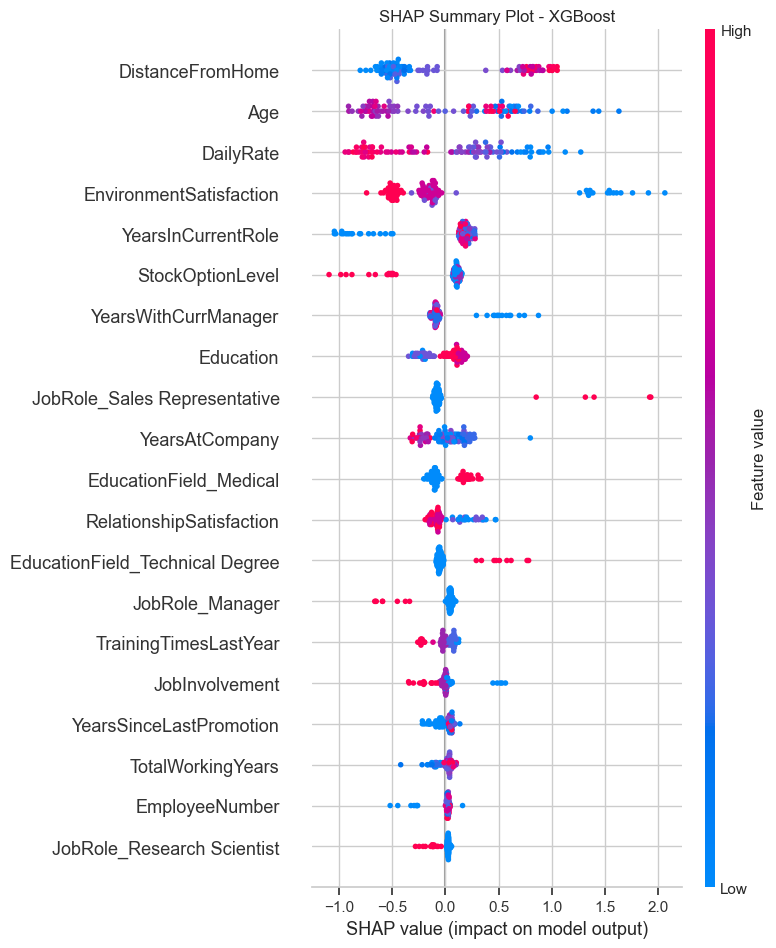

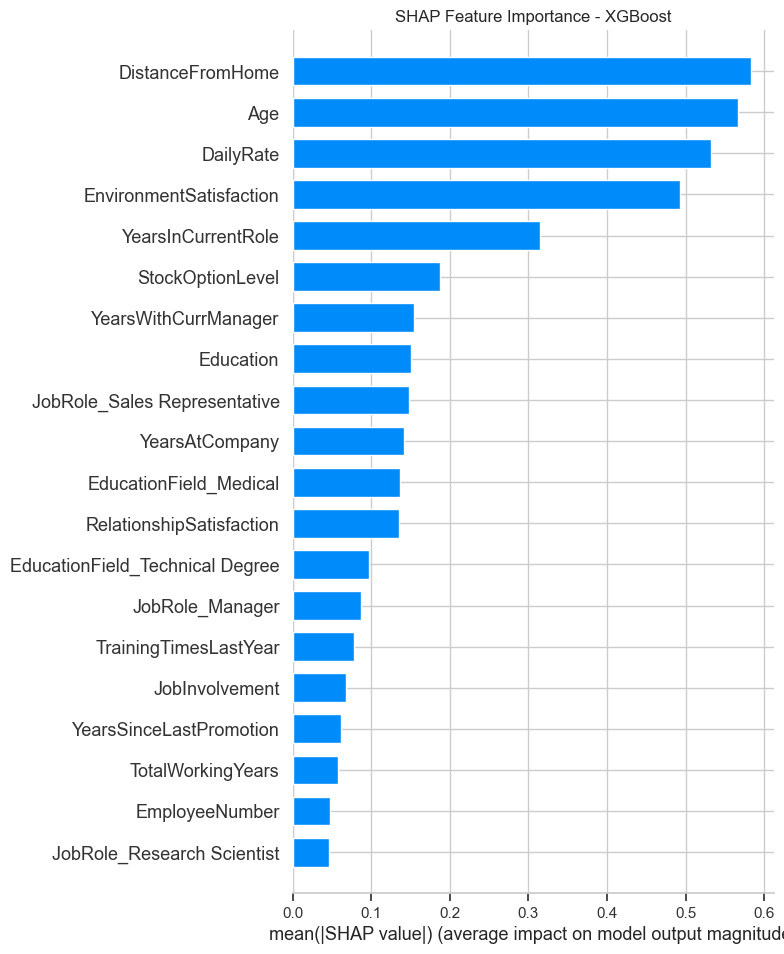

In [11]:
# SHAP Summary Plot (beeswarm)
shap.summary_plot(shap_values, X_sample, show=False)
plt.title("SHAP Summary Plot - XGBoost")
plt.savefig("images/shap_summary_plot.png", dpi=300, bbox_inches="tight")
plt.show()
 
# SHAP Feature Importance (bar)
shap.summary_plot(shap_values, X_sample, plot_type="bar", show=False)
plt.title("SHAP Feature Importance - XGBoost")
plt.savefig("images/shap_feature_importance.png", dpi=300, bbox_inches="tight")
plt.show()

## 👤 Local Interpretability (Waterfall + Bar)
 
For a specific employee, SHAP can explain how each feature contributed to their attrition risk.  
We’ll show two visuals:
- **Waterfall Plot** → Directional push of each feature  
- **Bar Plot** → Top features ranked by contribution

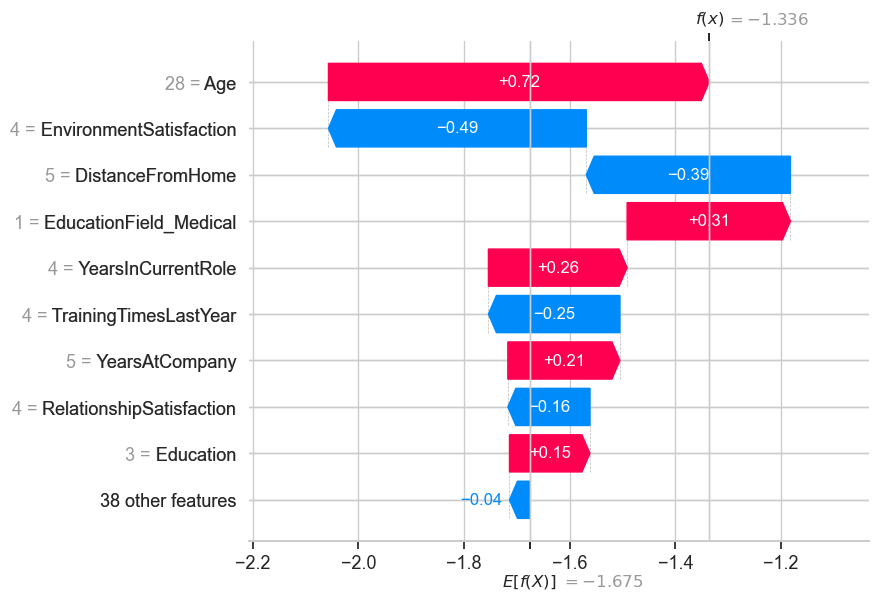

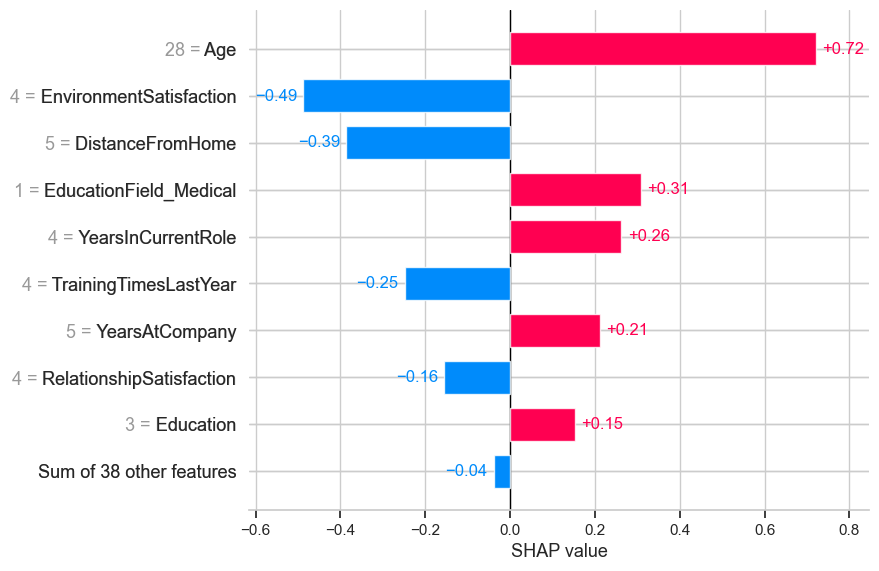

✅ Local SHAP plots saved: shap_waterfall_plot.png & shap_local_bar_plot.png


In [13]:
# Pick one employee from the SHAP sample
i = 0  # change index for a different employee
 
# Waterfall Plot (top 10 features)
shap.plots.waterfall(shap_values[i], max_display=10)
 
# Save waterfall plot
plt.savefig("images/shap_waterfall_plot.png", dpi=300, bbox_inches="tight")
plt.close()
 
# Bar Plot (top 10 features)
shap.plots.bar(shap_values[i], max_display=10)
 
# Save bar plot
plt.savefig("images/shap_local_bar_plot.png", dpi=300, bbox_inches="tight")
plt.close()
 
print("✅ Local SHAP plots saved: shap_waterfall_plot.png & shap_local_bar_plot.png")

## 🔀 Dependence Plot (Feature Interaction)
 
Shows how attrition risk changes with one feature (e.g., MonthlyIncome) across employees,  
and how it interacts with another feature.

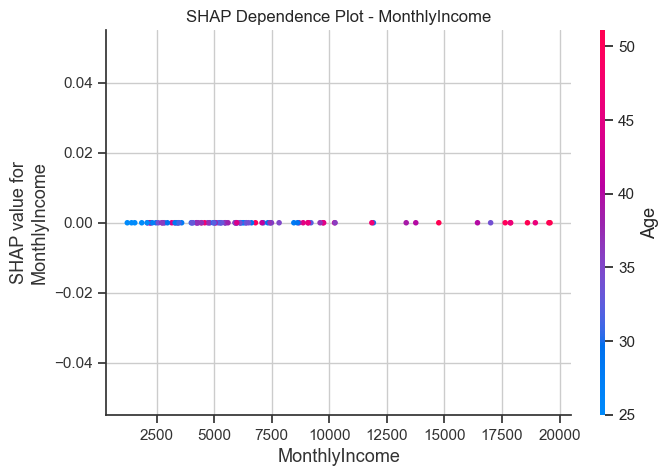

In [15]:
# Dependence plot with SHAP values (numeric) + feature data
shap.dependence_plot(
    "MonthlyIncome", 
    shap_values.values,   # SHAP contributions
    X_sample,             # Original features
    show=False
)
 
plt.title("SHAP Dependence Plot - MonthlyIncome")
plt.savefig("images/shap_dependence_plot.png", dpi=300, bbox_inches="tight")
plt.show()

# ✅ Conclusions (Project 6 — SHAP Interpretability)
 
- **Global Drivers:** SHAP summary and feature importance plots confirm that **Distance From Home, JobRole, and Daily Rate** are the strongest global drivers of attrition.  
- **Local Explanations:** For individual employees, SHAP waterfall and bar plots show *why* a prediction was made, highlighting the most influential factors (e.g., frequent overtime or lower income).  
- **Feature Interactions:** Dependence plots reveal how attrition risk changes across values of key features (e.g., attrition risk increases at lower income bands and with overtime).  
 
### 🔑 Why this matters:
- Moves the model from a **black box** → to **explainable AI**.  
- Builds **trust** for HR leaders, as they can see the reasoning behind predictions.  
- Supports **data-driven HR decision-making** while keeping it transparent and fair.  
 
---
 
### 🚀 Next Steps
- Integrate SHAP visuals into the **Streamlit Dashboard (Project 7)** for interactive exploration.  
- Combine SHAP outputs with **SQL pipelines (Project 8)** to deliver explainability at scale.